# TLDR - Linear regression in PyTorch

Find a linear regressor by successive approximation using mini-batch gradient descent.

---
tags: pytorch, tutorial, tldr, linear regression, dataloader, mini-batch gradient descent, optimizer, module

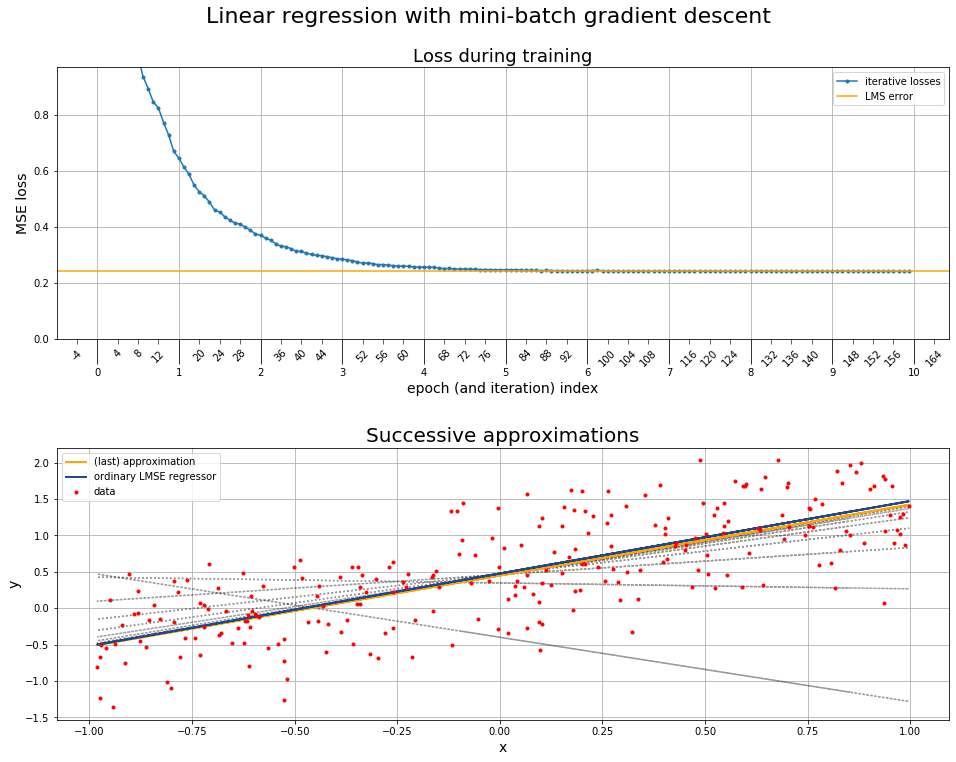

In [1]:
# IMPORTS
from sklearn.linear_model import LinearRegression # for comparison
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# DATA
# Number of samples
n_batches = 2**4 # nb of _mini_ batches in full batch
batch_size = 2**4
N = (n_batches - 1)*batch_size + batch_size//4 # size of dataset

# Samples
x = (-1 + 2*torch.rand(1, N)).view(-1, 1)
sigma = .5
h = sigma*torch.randn(1, N).view(-1, 1)
targs = .5 + x + h

# Dataset
ds = TensorDataset(x, targs)

# Dataloader
dl = DataLoader(ds, batch_size, shuffle=False)

# ORDINARY LEAST MEAN SQUARES LINEAR REGRESSOR
linreg = LinearRegression()
linreg.fit(x, targs)

preds_lms = linreg.predict(x)
loss_lms = (targs.numpy()**2- preds_lms**2).mean()

# CUSTOM LINEAR REGRESSOR CLASS
class LinearRegressor(nn.Module):
    def __init__(self):
        super(LinearRegressor, self).__init__()
        self.linear = nn.Linear(1, 1)
        
    def forward(self, x):
        y = self.linear(x)
        return y
    
# MODEL
model = LinearRegressor()

# CRITERION
criterion = nn.MSELoss(reduction='mean')

# LEARNING RATE
lr = .05

# OPTIMIZER
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# TRAINING MINI-BATCH GRADIENT DESCENT
losses = []
weights = []
biases = []

n_epochs = 10

for epoch in range(n_epochs):
    for x_b, targs_b in dl:
        preds_b = model(x_b)
        loss_b = criterion(preds_b, targs_b)
        loss_b.backward()
        optimizer.step()
        optimizer.zero_grad()

        with torch.no_grad():
            preds = model(x)
            loss = criterion(preds, targs)

        weights.append(model.linear.weight.item())
        biases.append(model.linear.bias.item())
        losses.append(loss.item())


# VISUALIZATION
fig, axs = plt.subplots(2, 1, figsize=(16, 12))
plt.subplots_adjust(hspace=.4)

# LOSS DURING TRAINING
ax = axs[0]
ax.plot(losses, '.-', label='iterative losses')
ax.axhline(loss_lms, color='Orange', label='LMS error')
ax.grid();
ax.legend();
ax.set_xlabel("iteration index", fontsize=14);
ax.set_ylabel("MSE loss", fontsize=14)
ax.set_title("Loss during training", fontsize=18);
ax.set_ylim(0, min(4*loss_lms, max(losses)))

ax.xaxis.set_major_locator(ticker.MultipleLocator(n_batches))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(n_batches//4))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda t, pos: f"{t//n_batches:.0f}"))
ax.xaxis.set_minor_formatter(ticker.FuncFormatter(lambda t, pos: f"{t:.0f}"))
ax.tick_params(which='major', axis='x', length=25)
ax.tick_params(which='minor', labelrotation=45, length=5)
ax.set_xlabel("epoch (and iteration) index", fontsize=14);

# SUCCESSIVE APPROXIMATIONS

ax = axs[1]
for w, b in zip(weights[::n_batches], biases[::n_batches]):
    preds = w*x+b
    
    ax.plot(x, preds.detach().numpy(), 'k:', alpha=.4)
ax.plot(x, preds.detach().numpy(), 'Orange', label='(last) approximation', linewidth=2) # last iteration
ax.plot(x, preds_lms, 'xkcd:cobalt', label='ordinary LMSE regressor', linewidth=2)
ax.plot(x, targs, linestyle='', marker='.', color='r', label='data');

ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("y", fontsize=14)
ax.set_title("Successive approximations", fontsize=20);
ax.legend();
ax.grid();


fig.suptitle("Linear regression with mini-batch gradient descent", fontsize=22, y=.95);

In [3]:
optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[0.9836]], requires_grad=True), Parameter containing:
   tensor([0.4716], requires_grad=True)],
  'lr': 0.05,
  'momentum': 0,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False}]